In [1]:
# Load data:
from util.Dataloader import Dataloader
from preprocessing import Preprocessing
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 1


# # Concatenate:
# dataloader00 = Dataloader('/MI_Jake_00')
# eeg_data00, eeg_labels00 = dataloader00.get_data()

# dataloader01 = Dataloader('/MI_Jake_01')
# eeg_data01, eeg_labels01 = dataloader01.get_data()

# dataloader02 = Dataloader('/MI_Jake_02')
# eeg_data02, eeg_labels02 = dataloader02.get_data()

# dataloader03 = Dataloader('/MI_Jake_03')
# eeg_data03, eeg_labels03 = dataloader03.get_data()

# eeg_data = np.concatenate((eeg_data00, eeg_data01, eeg_data02, eeg_data03), axis=1)
# print(eeg_data.shape)

# eeg_labels = np.concatenate((eeg_labels00, eeg_labels01, eeg_labels02, eeg_labels03), axis=0)
# print(eeg_labels.shape)



In [2]:
dataloader = Dataloader(['/MI_Jake_02', '/MI_Jake_01'])
eeg_data, eeg_labels = dataloader.get_data()

{'noblink': 0, 'break': 1, 'imagery_handL': 2, 'imagery_handR': 3, 'imagery_foot': 4}
[INFO]: Opening an xdf file
Creating RawArray with float64 data, n_channels=17, n_times=142730
    Range : 0 ... 142729 =      0.000 ...   570.916 secs
Ready.
{'noblink': 0, 'break': 1, 'imagery_handL': 2, 'imagery_handR': 3, 'imagery_foot': 4}
[INFO]: selected events:['break', 'imagery_handL', 'imagery_handR']
Used Annotations descriptions: ['break', 'imagery_handL', 'imagery_handR']
Not setting metadata
Not setting metadata
101 matching events found
No baseline correction applied
Loading data for 101 events and 501 original time points ...
0 bad epochs dropped
[INFO]: Acquired  Data and labels
/Users/jakepencharz/Documents/TUM/TUM-S2021/Cybathlon/project/data/MI_Jake_01
{'noblink': 0, 'break': 1, 'imagery_handL': 2, 'imagery_handR': 3, 'imagery_foot': 4}
[INFO]: Opening an xdf file
Creating RawArray with float64 data, n_channels=17, n_times=144366
    Range : 0 ... 144365 =      0.000 ...   577.460 

In [4]:
eeg_labels.shape

(101202,)

Shape of trials[left]: (8, 500, 25)
Shape of trials[right]: (8, 500, 25)


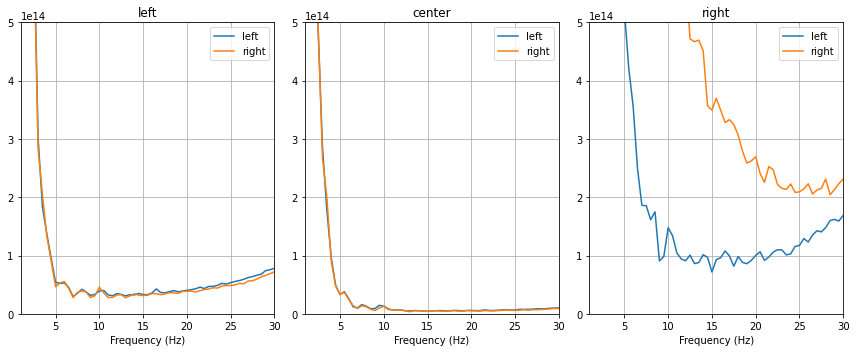

In [2]:
cl1 = 'left'
cl2 = 'right'


preprocessor = Preprocessing(eeg_data, eeg_labels)
onsets, event_codes = preprocessor.get_onsets()
trials = preprocessor.define_trials(onsets, event_codes)

# cl1, cl2 = preprocessor.get_cl1_cl2()
psd_l, freqs = preprocessor.psd(trials[cl1])
psd_r, freqs = preprocessor.psd(trials[cl2])
trials_PSD = {cl1: psd_l, cl2: psd_r}


preprocessor.plot_psd(
    trials,
    trials_PSD,
    freqs,
    chan_lab=['left', 'center', 'right'],
    maxy= 500*1e12, # problem: orders of magnitude)
    chan_ind = [preprocessor.channel_names.index(ch) for ch in ['C3', 'Cz', 'C4']]
)



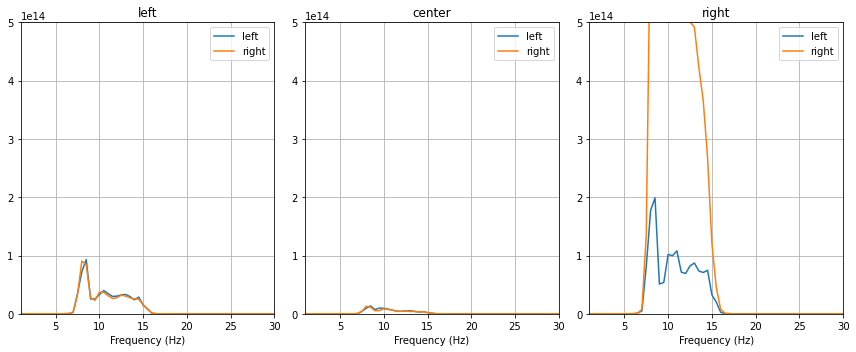

In [3]:
trials_filt = {cl1: preprocessor.bandpass(trials[cl1], 8, 15, preprocessor.sample_rate),
               cl2: preprocessor.bandpass(trials[cl2], 8, 15, preprocessor.sample_rate)}

psd_r, freqs = preprocessor.psd(trials_filt[cl1])
psd_f, freqs = preprocessor.psd(trials_filt[cl2])
trials_PSD2 = {cl1: psd_r, cl2: psd_f}


preprocessor.plot_psd(
    trials,
    trials_PSD2,
    freqs,
    chan_lab=['left', 'center', 'right'],
    maxy=500*1e12, # problem: orders of magnitude
    chan_ind = [preprocessor.channel_names.index(ch) for ch in ['C3', 'Cz', 'C4']]
)



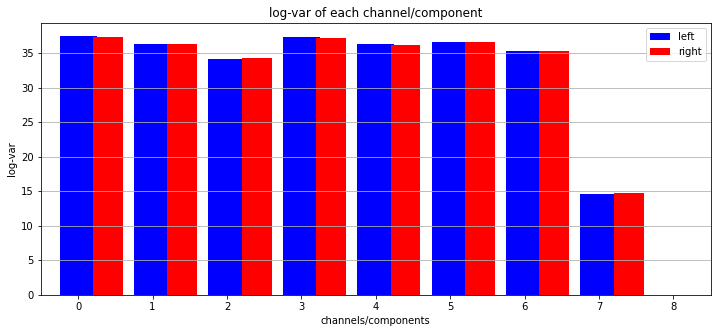

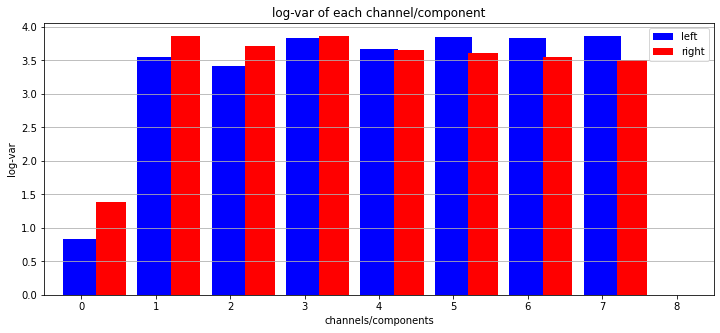

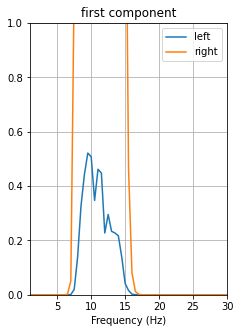

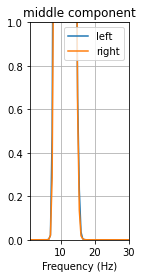

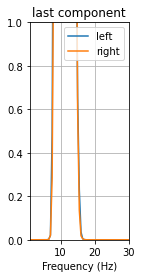

In [4]:
# Calculate the log(var) of the trials

trials_logvar = {cl1: preprocessor.logvar(trials_filt[cl1]),
                 cl2: preprocessor.logvar(trials_filt[cl2])}

preprocessor.plot_logvar(trials_logvar)


W = preprocessor.csp(trials_filt[cl1], trials_filt[cl2])
trials_csp = {cl1: preprocessor.apply_mix(W, trials_filt[cl1]),
              cl2: preprocessor.apply_mix(W, trials_filt[cl2])}

trials_logvar = {cl1: preprocessor.logvar(trials_csp[cl1]),
                 cl2: preprocessor.logvar(trials_csp[cl2])}
preprocessor.plot_logvar(trials_logvar)

psd_r, freqs = preprocessor.psd(trials_csp[cl1])
psd_f, freqs = preprocessor.psd(trials_csp[cl2])
trials_PSD2 = {cl1: psd_r, cl2: psd_f}

preprocessor.plot_psd(trials,
                      trials_PSD2,
                      freqs,
                      chan_lab=['first component', 'middle component', 'last component'],
                      maxy=1,
                      chan_ind= [0,7,-1]
                      )




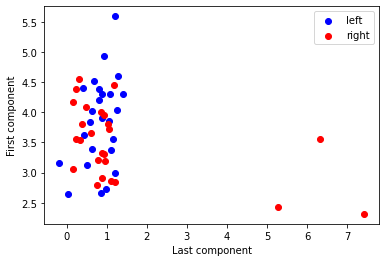

In [5]:
preprocessor.plot_scatter(trials_logvar[cl1], trials_logvar[cl2])




18
18
W: [ 0.27163575 -0.43981418]
b: -1.369718665251279


Text(0.5, 1.0, 'Training data')

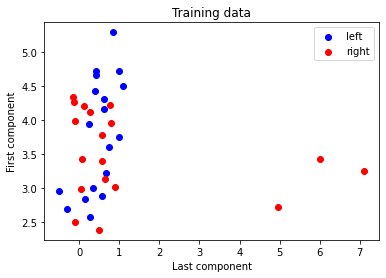

In [6]:
train_percentage = 0.75

# Calculate the number of trials for each class the above percentage boils down to
ntrain_r = int(trials_filt[cl1].shape[2] * train_percentage)
ntrain_f = int(trials_filt[cl2].shape[2] * train_percentage)
ntest_r = trials_filt[cl1].shape[2] - ntrain_r
ntest_f = trials_filt[cl2].shape[2] - ntrain_f

# Splitting the frequency filtered signal into a train and test set
train = {cl1: trials_filt[cl1][:,:,:ntrain_r],
         cl2: trials_filt[cl2][:,:,:ntrain_f]}

test = {cl1: trials_filt[cl1][:,:,ntrain_r:],
        cl2: trials_filt[cl2][:,:,ntrain_f:]}

W = preprocessor.csp(train[cl1], train[cl2])

# Apply the CSP on both the training and test set
train[cl1] = preprocessor.apply_mix(W, train[cl1])
train[cl2] = preprocessor.apply_mix(W, train[cl2])
test[cl1] = preprocessor.apply_mix(W, test[cl1])
test[cl2] = preprocessor.apply_mix(W, test[cl2])

# Select only the first and last components for classification
comp = np.array([0,-1])
train[cl1] = train[cl1][comp,:,:]
train[cl2] = train[cl2][comp,:,:]
test[cl1] = test[cl1][comp,:,:]
test[cl2] = test[cl2][comp,:,:]

# Calculate the log-var
train[cl1] = preprocessor.logvar(train[cl1])
train[cl2] = preprocessor.logvar(train[cl2])
test[cl1] = preprocessor.logvar(test[cl1])
test[cl2] = preprocessor.logvar(test[cl2])

W,b = preprocessor.train_lda(train[cl1].T, train[cl2].T)

print('W:', W)
print('b:', b)

preprocessor.plot_scatter(train[cl1], train[cl2])
plt.title('Training data')

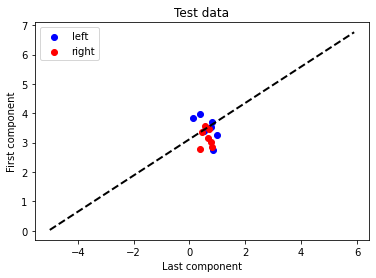

In [7]:
# Calculate decision boundary (x,y)
x = np.arange(-5, 6, 0.1)
y = (b - W[0]*x) / W[1]

# Plot the decision boundary
# plt.plot(x,y, linestyle='--', linewidth=2, color='k')

#plt.xlim(-5, 1)
#plt.ylim(-2.2, 1)

preprocessor.plot_scatter(test[cl1], test[cl2])
plt.title('Test data')
plt.plot(x,y, linestyle='--', linewidth=2, color='k')
#plt.xlim(-5, 1)
#plt.ylim(-2.2, 1)

plt.show()

In [8]:
# Calculate the accuracy:
# print(test[cl1])
# print(test[cl2])

# Formula: y = (b - W[0]*x_point) / W[1]

true_counter = 0
false_counter = 0
# Test classified as left:
for x_val, y_val in zip(test[cl1][0], test[cl1][1]):
    y_line = (b - W[0]*x_val) / W[1]
    if y_val > y_line:
        true_counter+=1
    else:
        false_counter+=1

# Test classified as right:
for x_val, y_val in zip(test[cl2][0], test[cl2][1]):
    y_line = (b - W[0]*x_val) / W[1]
    if y_val < y_line:
        true_counter+=1
    else:
        false_counter+=1
        

print(true_counter)
print(false_counter)
print(len(test[cl1][0]) + len(test[cl2][0]))
print("Accuracy: " + str(true_counter / (false_counter + true_counter)))

9
5
14
Accuracy: 0.6428571428571429


In [9]:
# Accuracies:

# Jake: 
# 0.5
# 0.5
# 0.64
# 0.5
# Overall: 0.52

# Sandra:
# 0.625
# 0.571
# 0.429
# 0.5
# Overall: 0.4565